<a href="https://colab.research.google.com/github/dobrotvorn/DataCon23/blob/main/Mini_task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Описание задания**
# Часть 1. Работа с данными

1) Просмотреть датасет на наличие выбросов и неверных данных

2) Разобраться в графиках из бейзлайна

3) Построить свои графики и выдвинуть по ним гипотезы

4) Отталкиваясь от этого, добавить некоторое количество новых дескрипторов при помощи rdkit (главное разобраться в коде, который это делает)

# Часть 2. Построение моделей

1) Построить свои модели на основе базовых регрессий из scikit-learn (минимум: обойти бейзлайн и попробовать хотя бы 3-4 модели
отличные от него)

2) Попробовать поработать с изменением параметров моделей и изменить соотношение тестовой/тренировочной выборки

3) Вывести графики feature importance полученных моделей

# Часть 3. Tensorflow

1) Провести эксперименты с архитектурами: количество слоев; функции активации; добавление дроп-аута/нормализации



## **Загрузка данных и библиотек**
# Импортируем и скачиваем библиотеки

In [360]:
!pip install pymatgen
!pip install rdkit
!pip install gdown -- quiet
!pip install fancyimpute --quiet
!pip install shap
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import plotly
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from fancyimpute import KNN
import pymatgen.core as mg
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from zipfile import ZipFile

ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


In [361]:
# тут захардкодим статичные переменные
global ordinal_encoder
global text_columns
global path2firstDb
global numerics
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
path2firstDb = '/content/firstDb.csv' if 'google.colab' in sys.modules else 'firstDb.csv'

# Скачиваем данные

In [362]:
url1 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR7whTOZIO16kGSfmtP3zHyXoRog0r6LVk_UZjpIhHwiRocAL5SIiqUyoBfpFXqe1fnyDsIOhTc7cjM/pub?gid=139006229&single=true&output=csv'
output1 = 'firstDb.csv'
gdown.download(url1, output1, quiet=True)

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(


'firstDb.csv'

## **Часть 1. Работа с ДС**

**Описание параметров:**

SMILES - Представление молекулы в текстовом формате smiles.

Solubility - Растворимость вещества в воде.

MolLogP - десятичный логарифм коэффициента разделения.

MolMR -  Относительный молекулярный вес соединения.

HeavyAtomCount - Количество атомов не-водорода в молекуле.

NumRotatableBonds - Число поворотных связей в молекуле.

NumValenceElectrons - Количество  валентных электронов в соединении.

NumAromaticRings - Количество ароматических колец в молекуле.

TPSA - Топологическая площадь поверхности полярных атомов в соединении.

LabuteASA - площадь поверхности молекулы, доступная для взаимодействия с молекулами растворителя.

BertzCT - Индекс, предназначенный для количественной оценки “сложности” молекул.

MolWt - Молекулярный вес соединения.


In [363]:
fdb = pd.read_csv(path2firstDb)
fdb.head(7)
fdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SMILES               9982 non-null   object 
 1   Solubility           9897 non-null   float64
 2   MolLogP              9924 non-null   float64
 3   MolMR                9915 non-null   float64
 4   HeavyAtomCount       9959 non-null   float64
 5   NumRotatableBonds    9974 non-null   float64
 6   NumValenceElectrons  9917 non-null   float64
 7   NumAromaticRings     9936 non-null   float64
 8   TPSA                 9939 non-null   float64
 9   LabuteASA            9917 non-null   float64
 10  BertzCT              9945 non-null   float64
dtypes: float64(10), object(1)
memory usage: 858.0+ KB


# Исключение выбросов

SMILES - 0%
Solubility - 1%
MolLogP - 1%
MolMR - 1%
HeavyAtomCount - 0%
NumRotatableBonds - 0%
NumValenceElectrons - 1%
NumAromaticRings - 0%
TPSA - 0%
LabuteASA - 1%
BertzCT - 0%


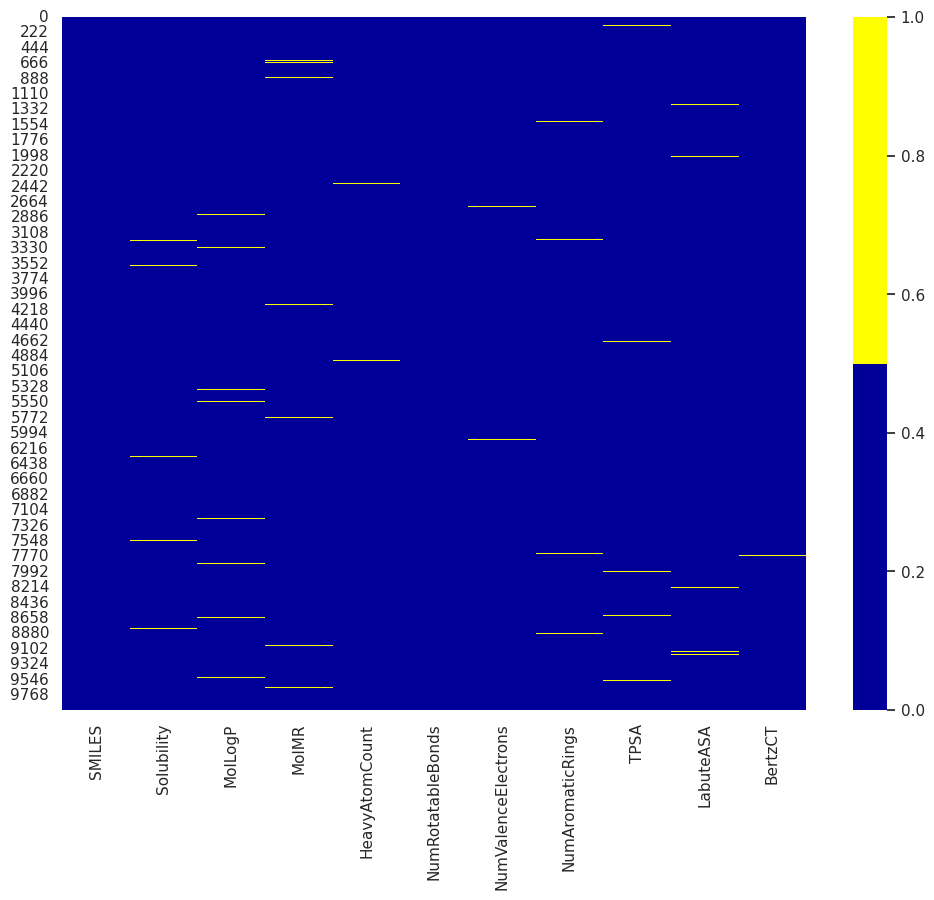

In [364]:
cols = fdb.columns
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(fdb[cols].isnull(), cmap=sns.color_palette(colours))
# процентный список пропущенных данных
for col in fdb.columns:
    pct_missing = np.mean(fdb[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

In [365]:
# Проверка на дубликаты по SMILES
df_dedupped = fdb.drop_duplicates(subset='SMILES')
print(fdb.shape)
print(df_dedupped.shape)
# Дубликаты отсутствуют

(9982, 11)
(9982, 11)


In [366]:
# Меняет значения выше четырёх медианных абсолютных отклонений (Фильтр Хэмпеля)
def hampel(vals_orig):
    vals = vals_orig.copy()
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()
    threshold = 4 * median_abs_deviation
    outlier_idx = difference > threshold
    vals[outlier_idx] = np.nan
    return(vals)

In [367]:
# def quart(vals_orig):
#   vals = vals_orig.copy()
#   Q1 = fdb.quantile(q=.25)
#   Q3 = fdb.quantile(q=.75)
#   quartiles = vals[col].quantile([0.25, 0.75])
#   IQR = quartiles[0.75] - quartiles[0.25]
#   data_clean = vals[~((vals < (Q1-1.5*IQR)) | (vals > (Q3+1.5*IQR))).any(axis=1)]
#   return(data_clean)
# fdb = fdb.loc[:, 'Solubility':]
# fdb = quart(fdb)
# fdb.info()

In [368]:
# Применим функцию (Фильтр Хэмпеля)
fdb = hampel(fdb)
fdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SMILES               9982 non-null   object 
 1   Solubility           9760 non-null   float64
 2   MolLogP              9107 non-null   float64
 3   MolMR                9287 non-null   float64
 4   HeavyAtomCount       9280 non-null   float64
 5   NumRotatableBonds    9205 non-null   float64
 6   NumValenceElectrons  9232 non-null   float64
 7   NumAromaticRings     9682 non-null   float64
 8   TPSA                 9336 non-null   float64
 9   LabuteASA            9228 non-null   float64
 10  BertzCT              9339 non-null   float64
dtypes: float64(10), object(1)
memory usage: 858.0+ KB


<ipython-input-366-978b85d10d0e>:4: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  difference = np.abs(vals.median()-vals)


<Axes: xlabel='Solubility'>

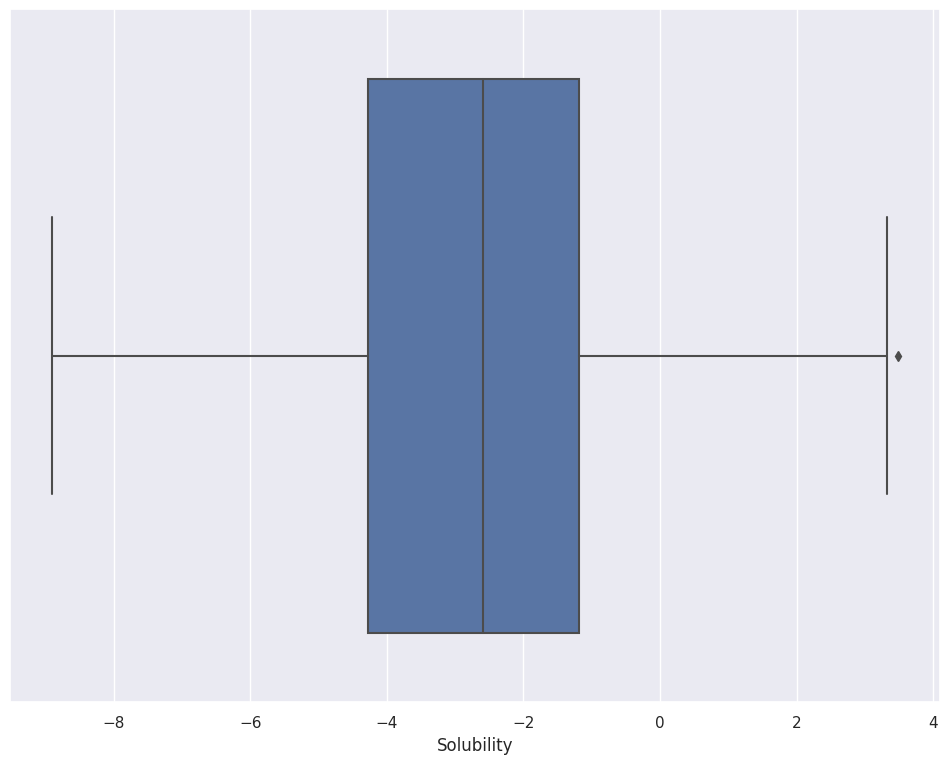

In [369]:
# Проверка на выбросы в колонке растворимости
sns.boxplot(data=fdb, x='Solubility')

In [370]:
# Удаление строк, где растворимость неизвестна
fdb = fdb.dropna(subset=['Solubility'])
fdb=fdb.reset_index(drop=True)

In [371]:
fdb

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,NaN,102.4454,23.0,NaN,142.0,0.0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.40550,51.9012,13.0,0.0,62.0,2.0,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.15250,36.8395,9.0,1.0,46.0,1.0,17.07,58.261134,NaN
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,NaN,NaN,NaN,10.0,NaN,NaN,120.72,NaN,NaN
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.48540,119.0760,31.0,NaN,164.0,2.0,56.60,183.183268,769.899934
...,...,...,...,...,...,...,...,...,...,...,...
9755,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,2.61700,78.6762,19.0,8.0,106.0,1.0,41.57,115.300645,374.236893
9756,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,-0.21440,109.5409,32.0,2.0,170.0,1.0,NaN,182.429237,1148.584975
9757,c1(cc(ccc1C(C)C)C)O,-2.190000,2.82402,46.9328,11.0,1.0,60.0,1.0,20.23,67.685405,251.049732
9758,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,5.09308,131.6560,33.0,NaN,180.0,2.0,63.95,198.569223,938.203977


In [372]:
# Заполнение колонки MolLogP из rdkit
def get_mollogp(smiles):
  new_mol=Chem.MolFromSmiles(smiles)
  a = Chem.Crippen.MolLogP(new_mol)
  return a

fdb['MolLogP'] = fdb['SMILES'].apply(get_mollogp)
fdb.head()

[07:23:04] WARNING: not removing hydrogen atom without neighbors
[07:23:04] WARNING: not removing hydrogen atom without neighbors
[07:23:04] WARNING: not removing hydrogen atom without neighbors
[07:23:04] WARNING: not removing hydrogen atom without neighbors
[07:23:04] WARNING: not removing hydrogen atom without neighbors
[07:23:04] WARNING: not removing hydrogen atom without neighbors
[07:23:04] WARNING: not removing hydrogen atom without neighbors
[07:23:04] WARNING: not removing hydrogen atom without neighbors
[07:23:04] WARNING: not removing hydrogen atom without neighbors
[07:23:05] WARNING: not removing hydrogen atom without neighbors
[07:23:05] WARNING: not removing hydrogen atom without neighbors
[07:23:05] WARNING: not removing hydrogen atom without neighbors
[07:23:05] WARNING: not removing hydrogen atom without neighbors
[07:23:05] WARNING: not removing hydrogen atom without neighbors
[07:23:05] WARNING: not removing hydrogen atom without neighbors
[07:23:05] WARNING: not r

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,3.9581,102.4454,23.0,NaN,142.0,0.0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13.0,0.0,62.0,2.0,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9.0,1.0,46.0,1.0,17.07,58.261134,NaN
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,NaN,NaN,10.0,NaN,NaN,120.72,NaN,NaN
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31.0,NaN,164.0,2.0,56.60,183.183268,769.899934


In [373]:
# Заполнение колонки MolMR из rdkit
def get_molmr(smiles):
  new_mol=Chem.MolFromSmiles(smiles)
  a = Chem.Crippen.MolMR(new_mol)
  return a

fdb['MolMR'] = fdb['SMILES'].apply(get_molmr)
fdb.head()

[07:23:09] WARNING: not removing hydrogen atom without neighbors
[07:23:09] WARNING: not removing hydrogen atom without neighbors
[07:23:09] WARNING: not removing hydrogen atom without neighbors
[07:23:09] WARNING: not removing hydrogen atom without neighbors
[07:23:09] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not removing hydrogen atom without neighbors
[07:23:10] WARNING: not r

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,3.9581,102.4454,23.0,NaN,142.0,0.0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13.0,0.0,62.0,2.0,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9.0,1.0,46.0,1.0,17.07,58.261134,NaN
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,200.7106,NaN,10.0,NaN,NaN,120.72,NaN,NaN
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31.0,NaN,164.0,2.0,56.60,183.183268,769.899934


In [374]:
# Заполнение колонки HeavyAtomCount из rdkit
def get_heavyatom(smiles):
  new_mol=Chem.MolFromSmiles(smiles)
  a = Chem.Lipinski.HeavyAtomCount(new_mol)
  return a

fdb['HeavyAtomCount'] = fdb['SMILES'].apply(get_heavyatom)
fdb.head()

[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not removing hydrogen atom without neighbors
[07:23:21] WARNING: not r

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,3.9581,102.4454,23,NaN,142.0,0.0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13,0.0,62.0,2.0,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9,1.0,46.0,1.0,17.07,58.261134,NaN
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,200.7106,53,10.0,NaN,NaN,120.72,NaN,NaN
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31,NaN,164.0,2.0,56.60,183.183268,769.899934


In [375]:
# Заполнение колонки NumRotatableBonds из rdkit
def get_rotatablebonds(smiles):
  new_mol=Chem.MolFromSmiles(smiles)
  a = Chem.Lipinski.NumRotatableBonds(new_mol)
  return a

fdb['NumRotatableBonds'] = fdb['SMILES'].apply(get_rotatablebonds)
fdb.head()

[07:23:24] WARNING: not removing hydrogen atom without neighbors
[07:23:24] WARNING: not removing hydrogen atom without neighbors
[07:23:24] WARNING: not removing hydrogen atom without neighbors
[07:23:24] WARNING: not removing hydrogen atom without neighbors
[07:23:24] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not removing hydrogen atom without neighbors
[07:23:25] WARNING: not r

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,3.9581,102.4454,23,17,142.0,0.0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13,0,62.0,2.0,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9,1,46.0,1.0,17.07,58.261134,NaN
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,200.7106,53,10,NaN,NaN,120.72,NaN,NaN
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31,12,164.0,2.0,56.60,183.183268,769.899934


In [376]:
# Заполнение колонки NumValenceElectrons из rdkit
def get_valenceelectrons(smiles):
  new_mol=Chem.MolFromSmiles(smiles)
  a = Chem.Descriptors.NumValenceElectrons(new_mol)
  return a

fdb['NumValenceElectrons'] = fdb['SMILES'].apply(get_valenceelectrons)
fdb.head()

[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:34] WARNING: not removing hydrogen atom without neighbors
[07:23:35] WARNING: not removing hydrogen atom without neighbors
[07:23:35] WARNING: not removing hydrogen atom without neighbors
[07:23:35] WARNING: not removing hydrogen atom without neighbors
[07:23:35] WARNING: not r

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,3.9581,102.4454,23,17,142,0.0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13,0,62,2.0,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9,1,46,1.0,17.07,58.261134,NaN
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,200.7106,53,10,264,NaN,120.72,NaN,NaN
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31,12,164,2.0,56.60,183.183268,769.899934


In [377]:
# Заполнение колонки NumAromaticRings из rdkit
def get_aromrings(smiles):
  new_mol=Chem.MolFromSmiles(smiles)
  a = Chem.Lipinski.NumAromaticRings(new_mol)
  return a

fdb['NumAromaticRings'] = fdb['SMILES'].apply(get_aromrings)
fdb.head()

[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not removing hydrogen atom without neighbors
[07:23:39] WARNING: not r

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,3.9581,102.4454,23,17,142,0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13,0,62,2,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9,1,46,1,17.07,58.261134,NaN
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,200.7106,53,10,264,6,120.72,NaN,NaN
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31,12,164,2,56.60,183.183268,769.899934


In [378]:
# Заполнение колонки TPSA из rdkit
def get_tpsa(smiles):
  new_mol=Chem.MolFromSmiles(smiles)
  a = Chem.rdMolDescriptors.CalcTPSA(new_mol)
  return a

fdb['TPSA'] = fdb['SMILES'].apply(get_tpsa)
fdb.head()

[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:40] WARNING: not removing hydrogen atom without neighbors
[07:23:41] WARNING: not removing hydrogen atom without neighbors
[07:23:41] WARNING: not removing hydrogen atom without neighbors
[07:23:41] WARNING: not removing hydrogen atom without neighbors
[07:23:41] WARNING: not r

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,3.9581,102.4454,23,17,142,0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13,0,62,2,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9,1,46,1,17.07,58.261134,NaN
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,200.7106,53,10,264,6,120.72,NaN,NaN
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31,12,164,2,56.60,183.183268,769.899934


In [379]:
# Заполнение колонки LabuteASA из rdkit
def get_labuteasa(smiles):
  new_mol=Chem.MolFromSmiles(smiles)
  a = Chem.MolSurf.LabuteASA(new_mol)
  return a

fdb['LabuteASA'] = fdb['SMILES'].apply(get_labuteasa)
fdb.head()

[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not removing hydrogen atom without neighbors
[07:23:42] WARNING: not r

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,3.9581,102.4454,23,17,142,0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13,0,62,2,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9,1,46,1,17.07,58.261134,NaN
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,200.7106,53,10,264,6,120.72,323.755434,NaN
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31,12,164,2,56.60,183.183268,769.899934


In [380]:
# Заполнение колонки BertzCT из rdkit
def get_bertzct(smiles):
  new_mol=Chem.MolFromSmiles(smiles)
  a = Chem.GraphDescriptors.BertzCT(new_mol)
  return a

fdb['BertzCT'] = fdb['SMILES'].apply(get_bertzct)
fdb.head()

[07:23:47] WARNING: not removing hydrogen atom without neighbors
[07:23:48] WARNING: not removing hydrogen atom without neighbors
[07:23:48] WARNING: not removing hydrogen atom without neighbors
[07:23:49] WARNING: not removing hydrogen atom without neighbors
[07:23:49] WARNING: not removing hydrogen atom without neighbors
[07:23:49] WARNING: not removing hydrogen atom without neighbors
[07:23:49] WARNING: not removing hydrogen atom without neighbors
[07:23:49] WARNING: not removing hydrogen atom without neighbors
[07:23:49] WARNING: not removing hydrogen atom without neighbors
[07:23:49] WARNING: not removing hydrogen atom without neighbors
[07:23:49] WARNING: not removing hydrogen atom without neighbors
[07:23:50] WARNING: not removing hydrogen atom without neighbors
[07:23:52] WARNING: not removing hydrogen atom without neighbors
[07:23:52] WARNING: not removing hydrogen atom without neighbors
[07:23:52] WARNING: not removing hydrogen atom without neighbors
[07:23:52] WARNING: not r

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,3.9581,102.4454,23,17,142,0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13,0,62,2,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9,1,46,1,17.07,58.261134,202.661065
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,200.7106,53,10,264,6,120.72,323.755434,1964.648666
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31,12,164,2,56.60,183.183268,769.899934


In [381]:
# Проверка
len(fdb[fdb['MolMR'] < 0])

0

In [382]:
#Изменение размера графика
sns.set(rc={'figure.figsize':(12,9)})

**Рассмотрим тепловую корреляционную карту и рисунки попарного отношения дескрипторов.**

Таргет **(растворимость в воде)** имеет умеренную отрицательную связь с десятичным логарифмом коэффициента разделения, относительным молекулярным весом соединения, количеством атомов не-водорода в молекуле, количеством валентных электронов в соединении, количеством ароматических колец в молекуле, площадью поверхности молекулы, доступной для взаимодействия с молекулами растворителя. Сильной связи не наблюдается ни с одним из дескрипторов.

**Сильная положительная связь наблюдается между дескрипторами:**

*   Количество атомов не-водорода в молекуле <=> Относительный молекулярный вес соединения
*   Число поворотных связей в молекуле <=> Относительный молекулярный вес соединения
*   Количество валентных электронов в соединении <=> Относительный молекулярный вес соединения
*   Площадь поверхности молекулы, доступная для взаимодействия с молекулами растворителя <=> Относительный молекулярный вес соединения
*   Индекс, предназначенный для количественной оценки “сложности” молекул <=> Относительный молекулярный вес соединения
*   Количество валентных электронов в соединении <=> Количество атомов не-водорода в молекуле
*   Площадь поверхности молекулы, доступная для взаимодействия с молекулами растворителя <=> Количество атомов не-водорода в молекуле
*   Индекс, предназначенный для количественной оценки “сложности” молекул <=> Количество атомов не-водорода в молекуле
*   Количество валентных электронов в соединении <=> Число поворотных связей в молекуле
*   Площадь поверхности молекулы, доступная для взаимодействия с молекулами растворителя <=> Количество валентных электронов в соединении
*   Индекс, предназначенный для количественной оценки “сложности” молекул <=> Количество атомов не-водорода в молекуле <=> Количество валентных электронов в соединении
*   Индекс, предназначенный для количественной оценки “сложности” молекул <=> Количество атомов не-водорода в молекуле <=> Количество ароматических колец в молекуле
*   Индекс, предназначенный для количественной оценки “сложности” молекул <=> Количество атомов не-водорода в молекуле <=> Площадь поверхности молекулы, доступная для взаимодействия с молекулами растворителя

Справка:
Принято считать, что сила коэффициента корреляции, как один показателей меры связи, дифференцируется на три уровня как для положительных, так и для отрицательных корреляций:
* r > 0,01 ≤ 0,29 – слабая положительная связь,
* r > 0,30 ≤ 0,69 – умеренная положительная связь,
* r > 0,70 ≤ 1,00 – сильная положительная связь,
* r > -0,01 ≤ -0,29 – слабая отрицательная связь,
* r > -0,30 ≤ -0,69 – умеренная отрицательная связь,
* r > -0,70 ≤ -1,00 – сильная отрицательная связь.







<ipython-input-383-3b20e3f5a754>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(fdb.corr(), cmap="YlGnBu", annot=True)


<Axes: >

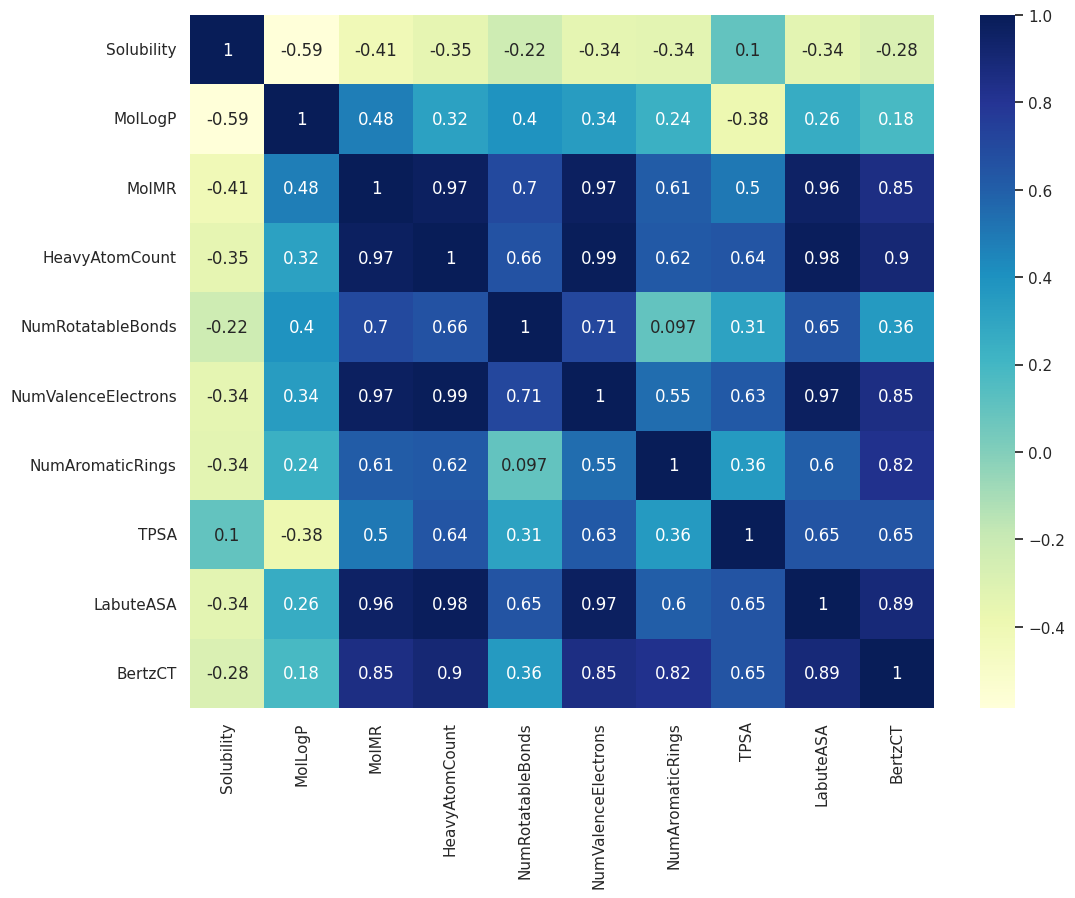

In [383]:
#Матрица корреляции между дескрипторами
sns.heatmap(fdb.corr(), cmap="YlGnBu", annot=True)

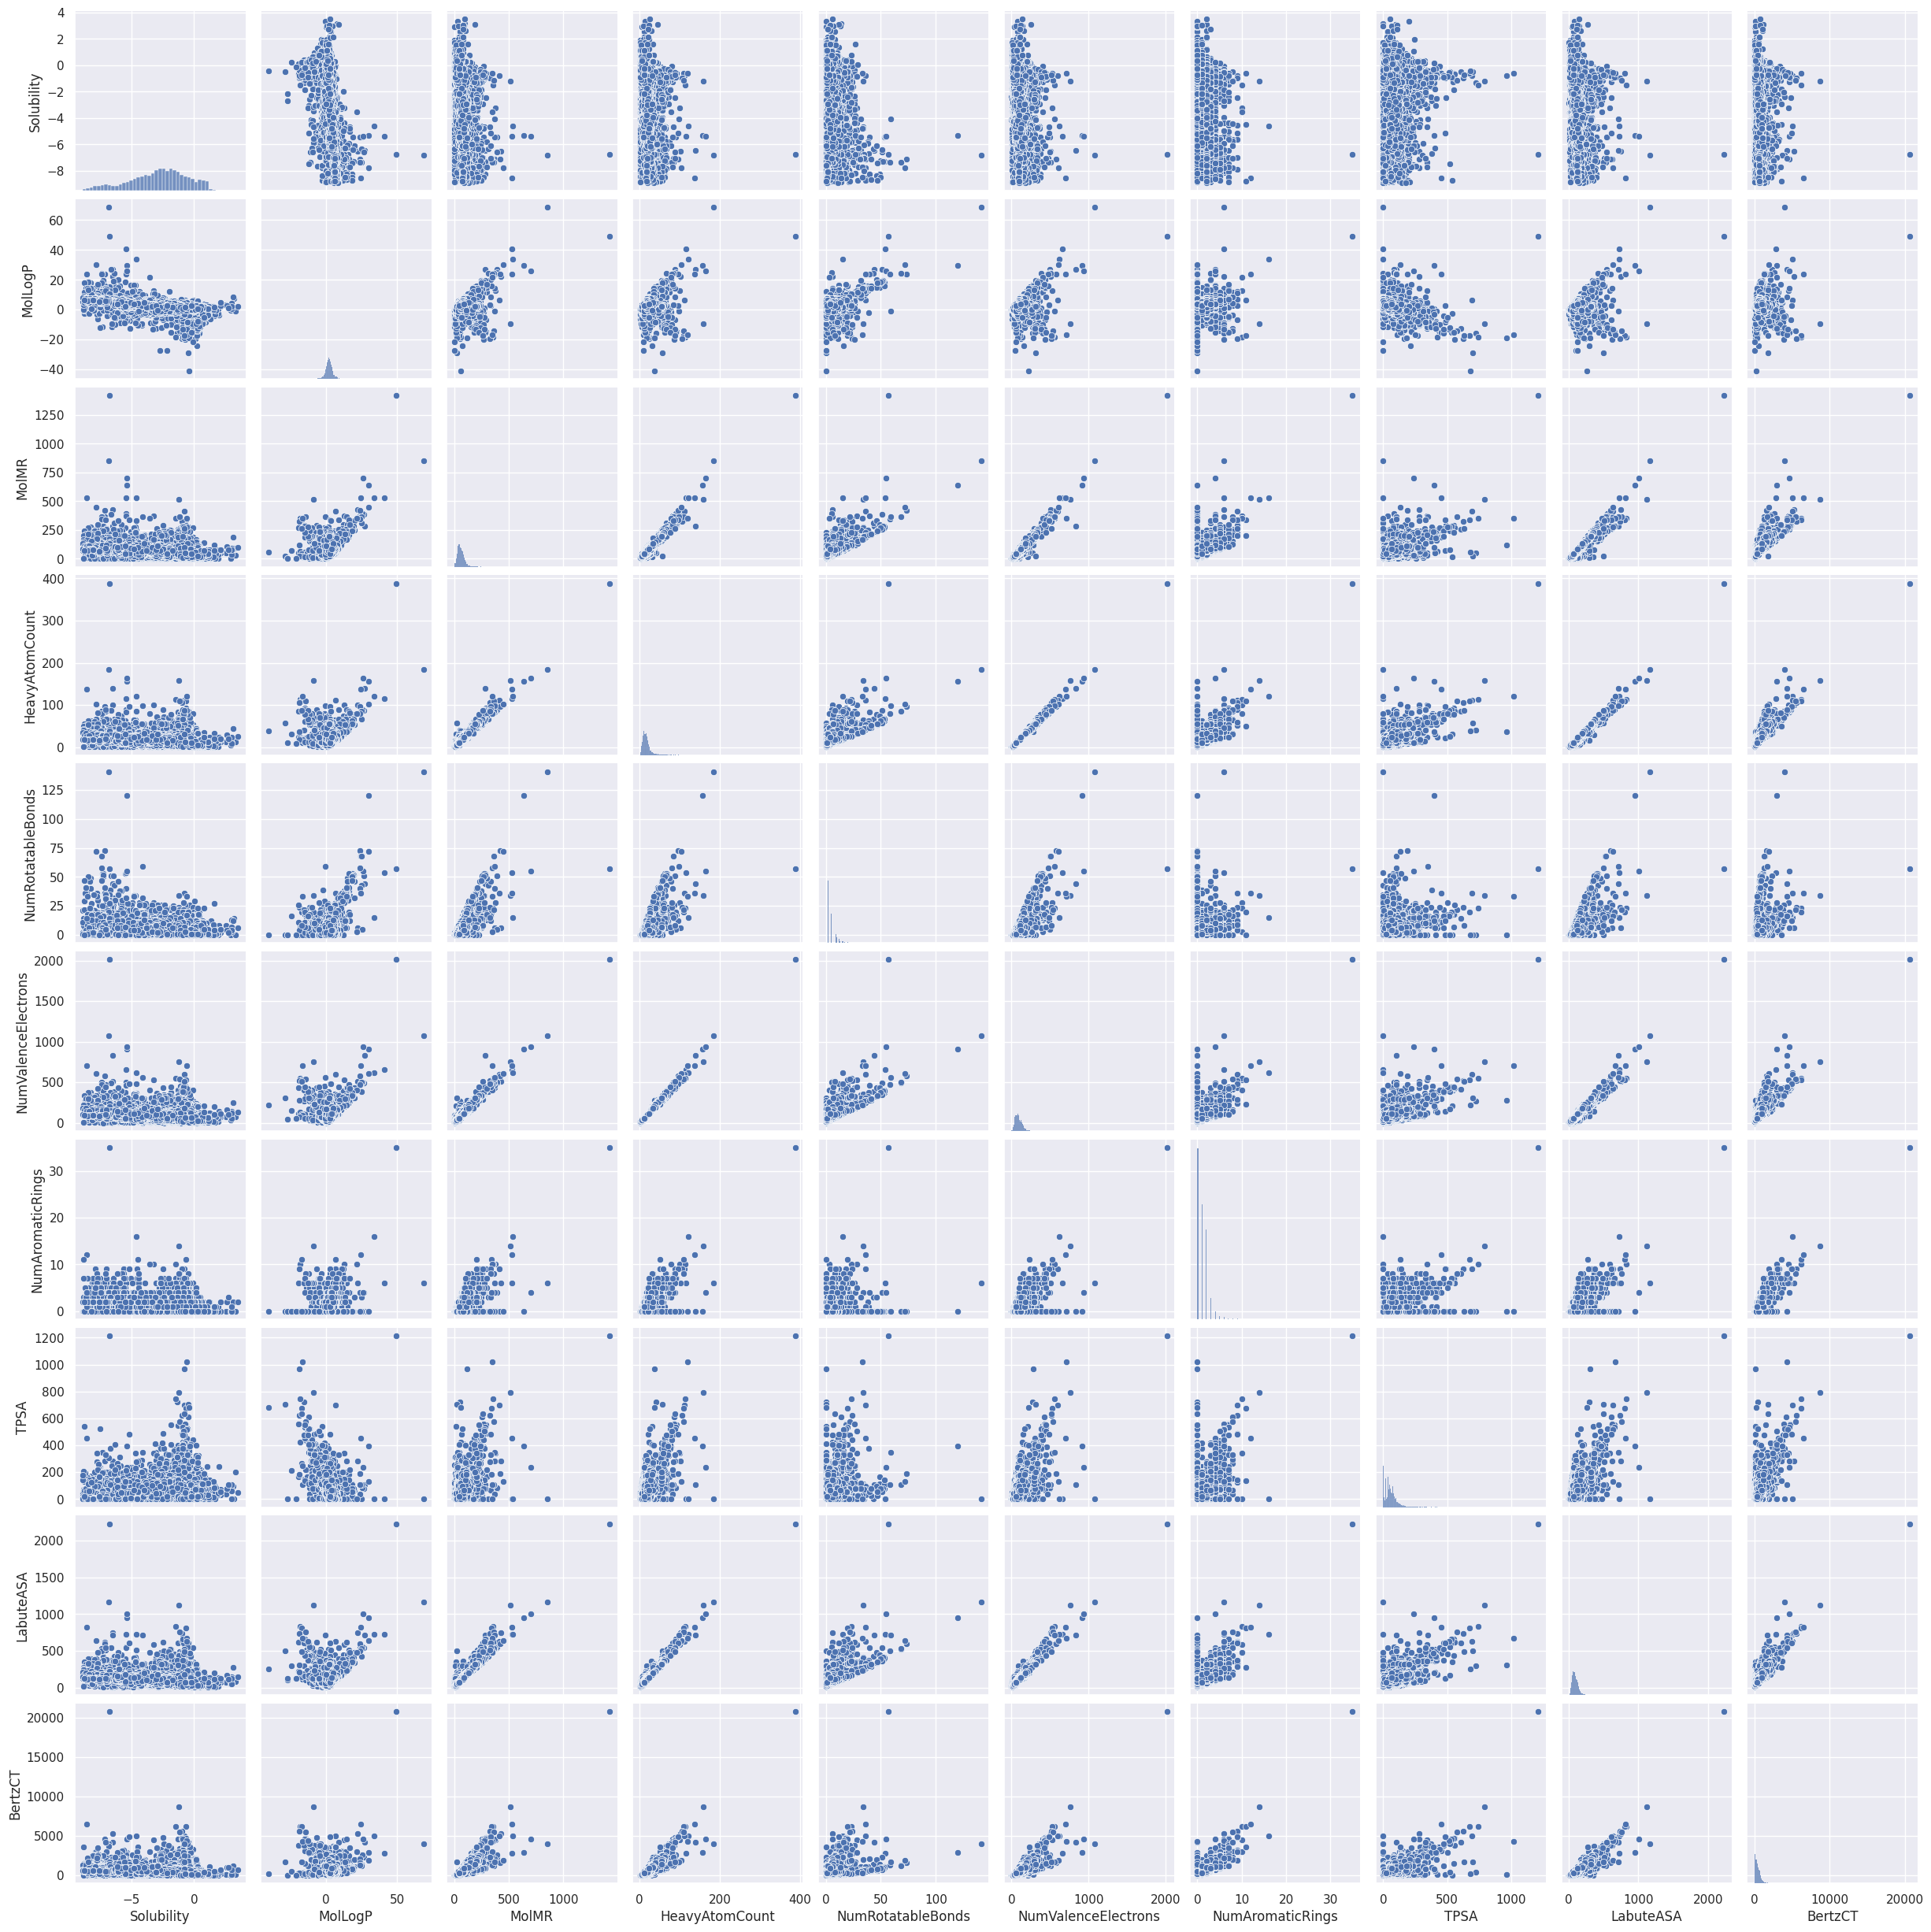

In [384]:
sns.pairplot(fdb.drop(columns = ["SMILES"], axis = 1))

Добавим в датасет 5 дополнительных дескрипторов и проверим корреляцию каждого с растворимостью:

*   Количество доноров водородной связи
*   Количество акцепторов водородной связи
*   Количество азота и кислорода
*   Количество NH или OH
*   Доля атомов C, гибридизованных SP3

In [385]:
# fdb["Number of Hydrogen Bond Donors"] = pd.Series(np.array([Chem.Lipinski.NumHDonors(Chem.MolFromSmiles(i)) for i in fdb["SMILES"]]), index=fdb.index)
# a = fdb['Solubility'] .corr(fdb['Number of Hydrogen Bond Donors'])
# print (a)

In [386]:
# fdb["NumHAcceptors"] = pd.Series(np.array([Chem.Lipinski.NumHAcceptors(Chem.MolFromSmiles(i)) for i in fdb["SMILES"]]), index=fdb.index)
# a = fdb['Solubility'] .corr(fdb['NumHAcceptors'])
# print (a)

In [387]:
# fdb["NOCount"] = pd.Series(np.array([Chem.Lipinski.NOCount(Chem.MolFromSmiles(i)) for i in fdb["SMILES"]]), index=fdb.index)
# a = fdb['Solubility'] .corr(fdb['NOCount'])
# print (a)

In [388]:
# fdb["NHOHCount"] = pd.Series(np.array([Chem.Lipinski.NHOHCount(Chem.MolFromSmiles(i)) for i in fdb["SMILES"]]), index=fdb.index)
# a = fdb['Solubility'] .corr(fdb['NHOHCount'])
# print (a)

In [389]:
# fdb["FractionCSP3"] = pd.Series(np.array([Chem.Lipinski.FractionCSP3(Chem.MolFromSmiles(i)) for i in fdb["SMILES"]]), index=fdb.index)
# a = fdb['Solubility'] .corr(fdb['FractionCSP3'])
# print (a)

In [390]:
fdb.head()

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,3.9581,102.4454,23,17,142,0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13,0,62,2,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9,1,46,1,17.07,58.261134,202.661065
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,200.7106,53,10,264,6,120.72,323.755434,1964.648666
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31,12,164,2,56.60,183.183268,769.899934


У показателя растворимости наблюдается слабая положительная связь с каждым из дополнительных дескрипторов.

In [452]:
X_train, X_test, y_train, y_test = train_test_split(fdb.drop(columns = ["SMILES", "Solubility"],axis=1), fdb["Solubility"], test_size=0.3, random_state=40)

In [453]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [454]:
r2_score(y_test, model.predict(X_test))

0.5024965837856572

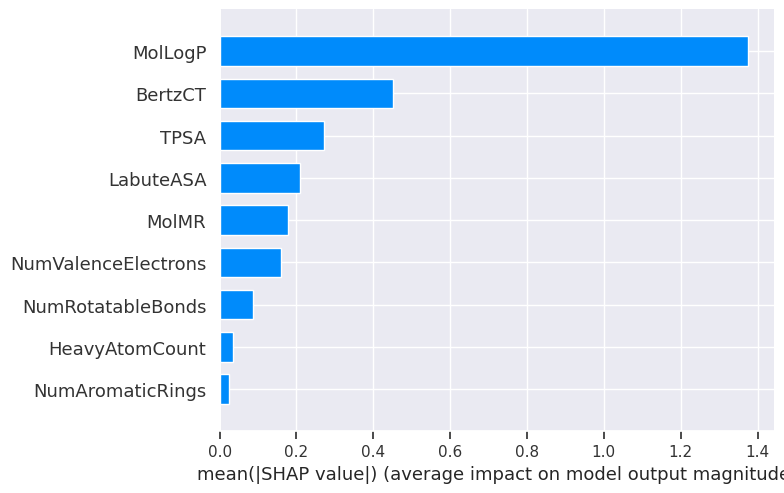

In [455]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type='bar')